In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from pathlib import Path
import re
from src.models import train_adult_income_baselines, train_german_credit_baselines
from src.fairness import evaluate_adult_income_fairness, summarize_fairness_results
from src.fairness import evaluate_german_credit_fairness

# Ensuring the output directory exists before writing any result tables or saving plots
# If results/ is missing, it will be created; if it already exists, nothing happens

RESULTS_DIR = Path("results")
PLOTS_DIR = RESULTS_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
def safe_filename(s: str) -> str:
    s = str(s).lower().strip()
    s = re.sub(r"[^\w\s-]", "", s)
    s = re.sub(r"[\s]+", "_", s)
    return s[:120]

def unique_path(base_path: Path) -> Path:
    # Avoiding overwriting: if file exists, add _2, _3, ...
    if not base_path.exists():
        return base_path
    stem = base_path.stem
    suffix = base_path.suffix
    i = 2
    while True:
        candidate = base_path.with_name(f"{stem}_{i}{suffix}")
        if not candidate.exists():
            return candidate
        i += 1

def save_plot(title: str, filename: str | None = None, dpi: int = 200):
    """
    Saving the current matplotlib figure to results/plots as PNG.
    """
    if filename is None:
        filename = safe_filename(title) or "plot"
        filename = filename + ".png"

    path = unique_path(PLOTS_DIR / filename)

    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    # marking current figure as already saved (prevents double-save if called twice)
    fig = plt.gcf()
    setattr(fig, "_autosave_done", True)

    print("Saved plot:", path.as_posix())


# auto save feature when plt.show() is called
_ORIGINAL_SHOW = plt.show  # keeping reference so it can be restored if needed
_PLOT_COUNTER = 0

def get_current_plot_title() -> str:
    fig = plt.gcf()

    # Trying suptitle first
    st = getattr(fig, "_suptitle", None)
    if st is not None and st.get_text().strip():
        return st.get_text().strip()

    # Fallback to first axes title
    axes = fig.get_axes()
    if axes and axes[0].get_title().strip():
        return axes[0].get_title().strip()

    return ""

def autosave_current_figure_if_needed():
    global _PLOT_COUNTER
    fig = plt.gcf()

    # If this figure was already saved, skip (prevents duplicates)
    if getattr(fig, "_autosave_done", False):
        return

    title = get_current_plot_title()
    if not title:
        _PLOT_COUNTER += 1
        title = f"plot_{_PLOT_COUNTER:03d}"

    save_plot(title)

def show(*args, **kwargs):
    # Saving before showing
    try:
        autosave_current_figure_if_needed()
    except Exception as e:
        print("WARNING: autosave failed:", e)

    return _ORIGINAL_SHOW(*args, **kwargs)

# Monkey-patch matplotlib show
plt.show = show
print("Autosave enabled: every plt.show() will also save a PNG to results/plots/")

Autosave enabled: every plt.show() will also save a PNG to results/plots/


In [3]:
# Training baseline (unmitigated) models for both datasets
# Each function returns a dictionary mapping model name -> fitted sklearn Pipeline
adult_models = train_adult_income_baselines()
german_models = train_german_credit_baselines()

# Printing the available model identifiers
print("Adult income models:", list(adult_models.keys()))
print("German credit models:", list(german_models.keys()))


[Adult income] dummy: val accuracy = 0.751
[Adult income] logreg: val accuracy = 0.847
[Adult income] tree: val accuracy = 0.814
[Adult income] rf: val accuracy = 0.851
[Adult income] gb: val accuracy = 0.859
[German credit] dummy: val accuracy = 0.700
[German credit] logreg: val accuracy = 0.795
[German credit] tree: val accuracy = 0.720
[German credit] rf: val accuracy = 0.765
[German credit] gb: val accuracy = 0.760
Adult income models: ['dummy', 'logreg', 'tree', 'rf', 'gb']
German credit models: ['dummy', 'logreg', 'tree', 'rf', 'gb']


In [4]:
# Evaluating fairness + performance metrics for all Adult Income baseline models on the TEST split,
# using "sex" as the protected attribute (grouping variable for MetricFrame)
adult_results_sex = evaluate_adult_income_fairness(adult_models, protected_attr="sex")
# Converting the MetricFrame outputs into a flat summary table (one row per model) including accuracy and key fairness indicators
adult_summary_sex = summarize_fairness_results(adult_results_sex, dataset_name="adult_income")
# Displaying the summary table
display(adult_summary_sex)
# Saving the results for discussion 
adult_summary_sex.to_csv("results/adult_baseline_fairness_sex.csv", index=False)
print("Saved: results/adult_baseline_fairness_sex.csv")



Adult income model: dummy (protected: sex)
Overall metrics:
accuracy          0.754316
precision         0.000000
recall            0.000000
f1                0.000000
selection_rate    0.000000
tpr               0.000000
fpr               0.000000
dtype: float64

By group:
        accuracy  precision  recall   f1  selection_rate  tpr  fpr
sex                                                               
Female  0.886627        0.0     0.0  0.0             0.0  0.0  0.0
Male    0.690253        0.0     0.0  0.0             0.0  0.0  0.0

Adult income model: logreg (protected: sex)
Overall metrics:
accuracy          0.848207
precision         0.733487
recall            0.600270
f1                0.660226
selection_rate    0.201062
tpr               0.600270
fpr               0.071039
dtype: float64

By group:
        accuracy  precision    recall        f1  selection_rate       tpr  \
sex                                                                         
Female  0.927743   0.7451

,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,false_positive_rate_diff,average_odds_diff,predictive_parity_diff
0,adult_income,dummy,0.754316,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
1,adult_income,logreg,0.848207,0.733487,0.600270,0.660226,0.173951,0.325275,0.057805,0.076124,0.066965,0.013494
2,adult_income,tree,0.806707,0.605004,0.614324,0.609629,0.179032,0.418489,0.048988,0.094963,0.071975,0.121531
3,adult_income,rf,0.847410,0.722398,0.615405,0.664623,0.179827,0.328904,0.069282,0.079130,0.074206,0.007492
4,adult_income,gb,0.865870,0.794737,0.612162,0.691603,0.164263,0.323547,0.057010,0.056715,0.056863,0.021670


Saved: results/adult_baseline_fairness_sex.csv


In [5]:
# Evaluating the same Adult Income baseline models using "race" as the protected attribute for comparison
try:
    adult_results_race = evaluate_adult_income_fairness(adult_models, protected_attr="race")
    # Summarizing the MetricFrame result
    adult_summary_race = summarize_fairness_results(adult_results_race, dataset_name="adult_income")
    display(adult_summary_race)
    # Saving results
    adult_summary_race.to_csv("results/adult_baseline_fairness_race.csv", index=False)
    print("Saved: results/adult_baseline_fairness_race.csv")
except Exception as e:
    print("Race evaluation skipped or failed:", e)



Adult income model: dummy (protected: race)
Overall metrics:
accuracy          0.754316
precision         0.000000
recall            0.000000
f1                0.000000
selection_rate    0.000000
tpr               0.000000
fpr               0.000000
dtype: float64

By group:
                    accuracy  precision  recall   f1  selection_rate  tpr  fpr
race                                                                          
Amer-Indian-Eskimo  0.872483        0.0     0.0  0.0             0.0  0.0  0.0
Asian-Pac-Islander  0.703431        0.0     0.0  0.0             0.0  0.0  0.0
Black               0.880936        0.0     0.0  0.0             0.0  0.0  0.0
Other               0.803279        0.0     0.0  0.0             0.0  0.0  0.0
White               0.740324        0.0     0.0  0.0             0.0  0.0  0.0

Adult income model: logreg (protected: race)
Overall metrics:
accuracy          0.848207
precision         0.733487
recall            0.600270
f1                0.660226

,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,false_positive_rate_diff,average_odds_diff,predictive_parity_diff
0,adult_income,dummy,0.754316,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
1,adult_income,logreg,0.848207,0.733487,0.600270,0.660226,0.229981,0.169626,0.422793,0.089145,0.255969,0.166667
2,adult_income,tree,0.806707,0.605004,0.614324,0.609629,0.200579,0.380030,0.219697,0.140617,0.180157,0.166667
3,adult_income,rf,0.847410,0.722398,0.615405,0.664623,0.209205,0.224039,0.361896,0.087357,0.224627,0.233333
4,adult_income,gb,0.865870,0.794737,0.612162,0.691603,0.209205,0.224039,0.264898,0.086384,0.175641,0.134343


Saved: results/adult_baseline_fairness_race.csv


In [6]:
# Evaluating fairness + performance metrics for all German Credit baseline models on the TEST split,
# using "sex" as the protected attribute
german_results = evaluate_german_credit_fairness(german_models, protected_attr="sex")
# Converting the MetricFrame outputs into a flat summary table (one row per model)
# including accuracy and key fairness indicators
german_summary = summarize_fairness_results(german_results, dataset_name="german_credit")

display(german_summary)

# Saving the results for later discussion
german_summary.to_csv("results/german_baseline_fairness_sex.csv", index=False)
print("Saved: results/german_baseline_fairness_sex.csv")



German credit model: dummy (protected: sex)
Overall metrics:
accuracy          0.700000
precision         0.700000
recall            1.000000
f1                0.823529
selection_rate    1.000000
tpr               1.000000
fpr               1.000000
dtype: float64

By group:
        accuracy  precision  recall        f1  selection_rate  tpr  fpr
sex                                                                    
female  0.666667   0.666667     1.0  0.800000             1.0  1.0  1.0
male    0.714286   0.714286     1.0  0.833333             1.0  1.0  1.0

German credit model: logreg (protected: sex)
Overall metrics:
accuracy          0.705000
precision         0.787234
recall            0.792857
f1                0.790036
selection_rate    0.705000
tpr               0.792857
fpr               0.500000
dtype: float64

By group:
        accuracy  precision  recall        f1  selection_rate    tpr    fpr
sex                                                                        
femal

,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,false_positive_rate_diff,average_odds_diff,predictive_parity_diff
0,german_credit,dummy,0.700,0.700000,1.000000,0.823529,0.000000,1.000000,0.000,0.000,0.0000,0.047619
1,german_credit,logreg,0.705,0.787234,0.792857,0.790036,0.007143,0.989899,0.025,0.075,0.0500,0.069986
2,german_credit,tree,0.675,0.758621,0.785714,0.771930,0.130952,0.828660,0.155,0.050,0.1025,0.065175
3,german_credit,rf,0.725,0.763975,0.878571,0.817276,0.007143,0.991150,0.005,0.025,0.0150,0.049594
4,german_credit,gb,0.750,0.796053,0.864286,0.828767,0.061905,0.920489,0.090,0.050,0.0700,0.072328


Saved: results/german_baseline_fairness_sex.csv


Saved plot: results/plots/adult_income_sex_baseline_accuracy_by_model.png


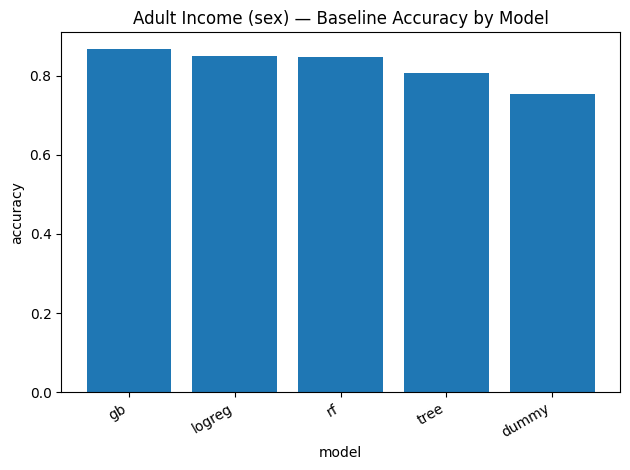

In [7]:
# Sorting, so best-performing models appear first
df = adult_summary_sex.sort_values("accuracy", ascending=False).reset_index(drop=True)

# Plotting baseline model accuracy as a simple bar chart
plt.figure()
plt.bar(df["model"], df["accuracy"])
plt.title("Adult Income (sex) — Baseline Accuracy by Model")
plt.xlabel("model")
plt.ylabel("accuracy")
plt.xticks(rotation=30, ha="right")
plt.show()


Saved plot: results/plots/adult_income_sex_statistical_parity_difference_by_model.png


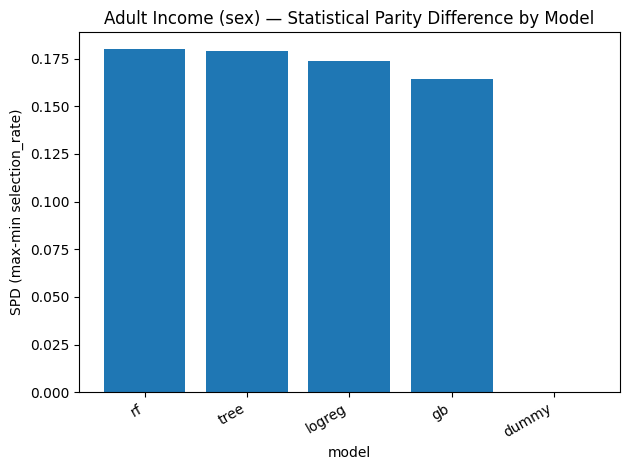

In [8]:
# Sorting models by Statistical Parity Difference
# SPD here is derived from the difference in selection_rate between the best- and worst-off groups
df = adult_summary_sex.sort_values("statistical_parity_diff", ascending=False).reset_index(drop=True)

# Plotting SPD as a bar chart to compare group-level selection rate disparities across models
plt.figure()
plt.bar(df["model"], df["statistical_parity_diff"])
plt.title("Adult Income (sex) — Statistical Parity Difference by Model")
plt.xlabel("model")
plt.ylabel("SPD (max-min selection_rate)")
plt.xticks(rotation=30, ha="right")
plt.show()

Saved plot: results/plots/adult_income_sex_equal_opportunity_difference_by_model.png


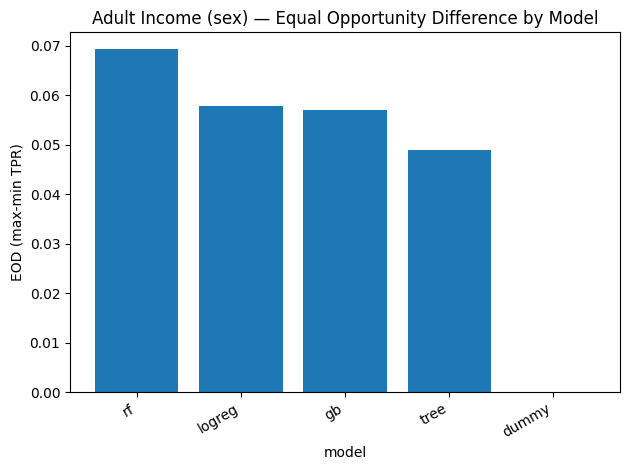

In [9]:
# Sorting models by Equal Opportunity Difference (EOD) so models with the largest TPR gap appear first
# EOD here is derived from the difference in true positive rate (TPR) between the best- and worst-off groups

df = adult_summary_sex.sort_values("equal_opportunity_diff", ascending=False).reset_index(drop=True)

# Plotting EOD as a bar chart to compare group-level TPR disparities across models
plt.figure()
plt.bar(df["model"], df["equal_opportunity_diff"])
plt.title("Adult Income (sex) — Equal Opportunity Difference by Model")
plt.xlabel("model")
plt.ylabel("EOD (max-min TPR)")
plt.xticks(rotation=30, ha="right")
plt.show()

Saved plot: results/plots/adult_income_sex_accuracy_vs_spd_baseline_models.png


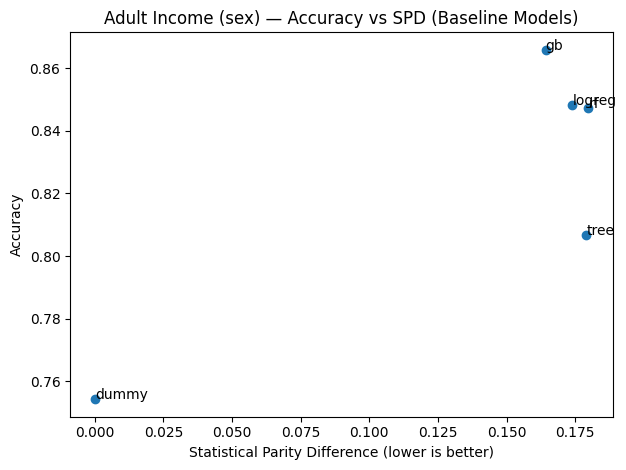

In [10]:
# Visualizing the fairness–performance trade-off for baseline models:
# x-axis = Statistical Parity Difference (SPD)  -> lower is "fairer" 
# y-axis = Accuracy                             -> higher is better performance
plt.figure()
plt.scatter(adult_summary_sex["statistical_parity_diff"], adult_summary_sex["accuracy"])

for _, r in adult_summary_sex.iterrows():
    plt.text(r["statistical_parity_diff"], r["accuracy"], r["model"])
plt.title("Adult Income (sex) — Accuracy vs SPD (Baseline Models)")
plt.xlabel("Statistical Parity Difference (lower is better)")
plt.ylabel("Accuracy")
plt.show()